In [23]:
%reload_ext autoreload
%autoreload 2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.ops.focal_loss import sigmoid_focal_loss
from torch.utils.data import DataLoader
from DatasetClass import KITTI_MOD_FIXED, ExtendedKittiMod
from ModelClass import UNET
from torch.utils.tensorboard import SummaryWriter
import sys
import os
import gc
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import PIL

# set device and clean up
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gc.collect()
torch.cuda.empty_cache()
print(f"running on '{device}'")


# dataset
# data_root = '/storage/remote/atcremers40/motion_seg/datasets/KITTI_MOD_fixed/training/'
data_root = "/storage/remote/atcremers40/motion_seg/datasets/Extended_MOD_Masks/"
data_transforms = transforms.Compose([
    transforms.ToTensor()
])
# dataset = KITTI_MOD_FIXED(data_root, data_transforms)
dataset = ExtendedKittiMod(data_root)

# specify some hyperparams
lr = 5e-3
batch_size = 2
epochs = 100

# data split and data loader
train_size = int(0.8 *  len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

# init model and pass to `device`
input_channels=6
output_channels=1
model = UNET(in_channels=input_channels, out_channels=output_channels).to(device)
model = model.float()

# for running single batch
# [data, targets] = next(iter(train_loader))
# print(len(np.where(targets[0] > 0)[0]))
# plt.imshow(targets[0].detach().cpu().permute(1,2,0).numpy())
# plt.show()

# loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()

running on 'cuda:0'
dirs loaded:
['2011_09_26_drive_0005_sync']


In [24]:
def run_val(loader, model):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            x = x.to(device=device).float()
            y = y.to(device=device).float()

            # forward
            scores = model(x)
            loss = sigmoid_focal_loss(scores, y, reduction="sum")
            # loss = criterion(scores, y)
            val_losses.append(loss.item())

            if batch_idx == 0:
                sigmoid = nn.Sigmoid()
                scores_rounded = torch.round(sigmoid(scores))
                writer.add_images("visualised_preds", scores_rounded, global_step=epoch+1)
                writer.add_images("visualised_gts", y, global_step=epoch+1)

        writer.add_scalar("val loss", sum(val_losses)/len(val_losses), epoch*len(val_loader)) 

    # set back to train ensures layers like dropout, batchnorm are used after eval
    model.train()
    return sum(val_losses)/len(val_losses)

In [25]:
# initialise tensorboard
now = datetime.now()
now_string = now.strftime("%d.%m.%Y_%H:%M:%S")
writer = SummaryWriter("runs/" + now_string)

# train network
print("train network ...")
train_loss = []
val_loss = []
for epoch in range(epochs):
    model.train()
    losses = []
    steps_per_epoch = len(train_loader)

    for batch_idx, (data, targets) in enumerate(train_loader):

        # move data to gpu if available
        data = data.to(device).float()
        targets = targets.to(device).float()

        # forward
        scores = model(data)
        loss = sigmoid_focal_loss(scores, targets, reduction="sum")
        # loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # adam step
        optimizer.step()

        losses.append(loss.item())

        if (batch_idx + 1) % 20 == 0:
            writer.add_scalar("training loss", sum(losses)/len(losses), epoch*steps_per_epoch + batch_idx)

    # print(f"Epoch {epoch}: loss => {sum(losses)/len(losses)}")
    train_loss.append(sum(losses)/len(losses))
    val_loss.append(run_val(val_loader, model))
    print(f"epoch [{epoch + 1}/{epochs}], train loss: {round(train_loss[-1], 5)}, val loss: {round(val_loss[-1], 5)}")

writer.close()

train network ...
epoch [1/100], train loss: 13722.86471, val loss: 6671.45592
epoch [2/100], train loss: 4515.94157, val loss: 8116.52141
epoch [3/100], train loss: 3835.39806, val loss: 35367.09351
epoch [4/100], train loss: 2779.07596, val loss: 4366.02866
epoch [5/100], train loss: 2305.73008, val loss: 13554.6853
epoch [6/100], train loss: 2031.50385, val loss: 1794.53861
epoch [7/100], train loss: 1891.53768, val loss: 2986.61311
epoch [8/100], train loss: 1569.31625, val loss: 2617.84188
epoch [9/100], train loss: 1359.92047, val loss: 1541.32674
epoch [10/100], train loss: 1338.26284, val loss: 1639.72794
epoch [11/100], train loss: 1515.92349, val loss: 1431.23026
epoch [12/100], train loss: 1327.71013, val loss: 1633.25974
epoch [13/100], train loss: 1135.39061, val loss: 1306.52851
epoch [14/100], train loss: 1153.9403, val loss: 2132.75299
epoch [15/100], train loss: 1058.75219, val loss: 1826.97003
epoch [16/100], train loss: 1047.99647, val loss: 1414.26297
epoch [17/100]

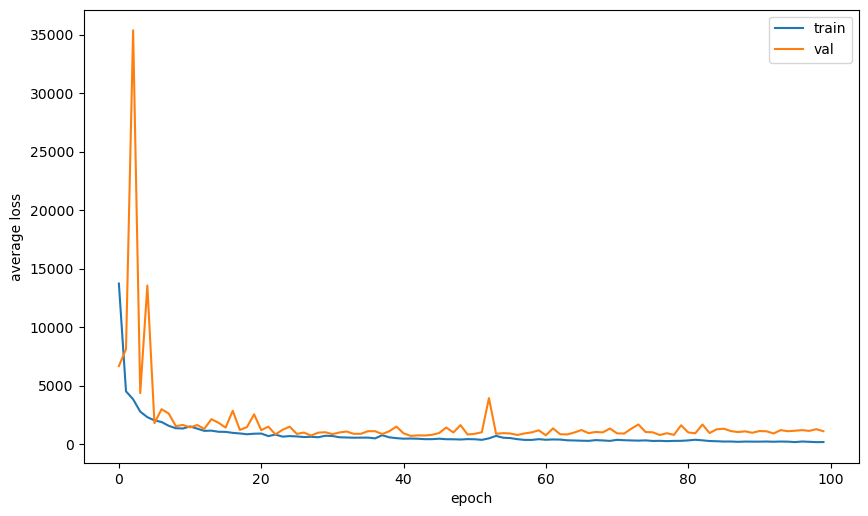

In [26]:
# plot losses for train and val
ax1 = list(range(len(train_loss)))
fig = plt.figure(figsize=(10,6), dpi=100)
plot_train = plt.plot(ax1, train_loss)
plot_val = plt.plot(list(range(len(val_loss))), val_loss)
plt.xlabel("epoch")
plt.ylabel("average loss")
plt.legend(["train", "val"])
plt.show()

In [28]:
  # save model weights
model_filename = "/storage/remote/atcremers40/motion_seg/saved_models/supervised_unet.pt"
torch.save(model, model_filename)